![qiskit_header.png](attachment:qiskit_header.png)

# Non-Clifford CNOT-Dihedral Randomized Benchmarking

- Last Updated: Feburary 19, 2020
- Requires: qiskit-terra 0.11, qiskit-ignis 0.3, qiskit-aer 0.3.4

## Introduction

**Non-Clifford CNOT-Dihedral Randomized Benchmarking** is a variant of the Randomized Benchmarking (RB) method that is used for benchmarking certain non-Clifford gates via randomization, taken from the so-called *CNOT-dihedral group* which is generated by CNOTs and a single qubit dihedral group $\langle T, X \rangle$.
The method is based on the paper "Scalable randomized benchmarking of non-Clifford gates"(https://arxiv.org/abs/1510.02720).

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module in order to perform interleaved RB.

## Table of Contents

1. [Select the parameters and generate CNOT-Dihedral RB sequences](#gen_RB_seq)
2. [Execute CNOT-Dihedral RB sequences](#ex_RB_seq)
3. [Fit CNOT-Dihedral RB results](#fit_RB)
4. [Generate interleaved and purity CNOT-Dihedral RB sequnces](#int_pur_RB)

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes 
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

## 1.1) Select the parameters of the non-Clifford CNOT-Dihedral RB run <a name='gen_RB_seq'></a>

First, we need to choose the regular RB parameters:

- **nseeds:** The number of seeds. For each seed there you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of CNOT-dihedral lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later)
- **align_cliffs:** If true adds a barrier across all qubits in rb_pattern after each set of elements

As well as another parameter for non-Clifford CNOT-Dihedral RB:

- **group_gates = 'CNOT-Dihedral'** 

In this example we have 3 qubits Q0,Q1,Q2. We are running 2Q RB (on qubits Q0,Q2) and 1Q RB (on qubit Q1) simultaneously, where there are three times as many 1Q gates.

In [2]:
#Number of qubits
nQ = 3
#There are 3 qubits: Q0,Q1,Q2.
#Number of seeds (random sequences)
nseeds = 5
#Number of elements in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)
#2Q RB on Q0,Q2 and 1Q RB on Q1
rb_pattern = [[0,2],[1]]
#Do three times as many 1Q elements
length_multiplier = [1,3]
# Non-Clifford CNOT-Dihedral RB
group_gates = 'CNOT-Dihedral'

## 1.2) Generate non-Clifford CNOT-Dihedral RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the non-Clifford CNOT-Dihedral RB sequences rb_cnotdihedral_Z_circs and rb_cnotdihedral_X_circs, which are a list of lists of quantum circuits, we run the function **rb.randomized_benchmarking_seq**.

This function returns:

- **rb_cnotdihedral_Z_circs:** A list of lists of circuits for the standard rb sequences where we measure the $|0 \dots 0 \rangle$ state (separate list for each seed).
- **xdata:** The CNOT-dihedral group elements lengths (with multiplier if applicable).
- **rb_cnotdihedral_X_circs:** A list of lists of circuits for the rb sequences where we measure the $|+ \dots + \rangle$ state (separate list for each seed).

In [3]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_opts['group_gates'] = group_gates
rb_opts['align_cliffs'] = True

rb_cnotdihedral_Z_circs, xdata, rb_cnotdihedral_X_circs = rb.randomized_benchmarking_seq(**rb_opts)

Making the n=2 CNOT-dihedral Table


As an example, we print the circuit corresponding to the first RB sequences:

(Note that rb_cnotdihedral_X_circs is the same as rb_cnotdihedral_Z_circs except of the Hadamard gates at the beginning and the end of the sequence).

In [4]:
print (rb_cnotdihedral_Z_circs[0][0])

          ┌──────────┐┌───┐┌───┐    ┌──────────┐  ░                       ░ »
qr_0: |0>─┤ U1(pi/2) ├┤ X ├┤ X ├────┤ U1(pi/2) ├──░───────────────────────░─»
          ├──────────┤├───┤└─┬─┘ ░ ┌┴──────────┴┐ ░ ┌───┐ ░ ┌────────┐ ░  ░ »
qr_1: |0>─┤ U1(pi/4) ├┤ X ├──┼───░─┤ U1(5.4978) ├───┤ X ├─░─┤ U1(pi) ├─░──░─»
         ┌┴──────────┤└───┘  │   ░ └────────────┘ ░ └───┘ ░ └────────┘ ░  ░ »
qr_2: |0>┤ U1(3.927) ├───────■────────────────────░───────────────────────░─»
         └───────────┘                            ░                       ░ »
 cr_0: 0 ═══════════════════════════════════════════════════════════════════»
                                                                            »
 cr_1: 0 ═══════════════════════════════════════════════════════════════════»
                                                                            »
 cr_2: 0 ═══════════════════════════════════════════════════════════════════»
                                                                

In [5]:
print (rb_cnotdihedral_X_circs[0][0])

         ┌───┐ ░  ┌──────────┐┌───┐┌───┐    ┌──────────┐  ░                   »
qr_0: |0>┤ H ├─░──┤ U1(pi/2) ├┤ X ├┤ X ├────┤ U1(pi/2) ├──░───────────────────»
         ├───┤ ░  ├──────────┤├───┤└─┬─┘ ░ ┌┴──────────┴┐ ░ ┌───┐ ░ ┌────────┐»
qr_1: |0>┤ H ├─░──┤ U1(pi/4) ├┤ X ├──┼───░─┤ U1(5.4978) ├───┤ X ├─░─┤ U1(pi) ├»
         ├───┤ ░ ┌┴──────────┤└───┘  │   ░ └────────────┘ ░ └───┘ ░ └────────┘»
qr_2: |0>┤ H ├─░─┤ U1(3.927) ├───────■────────────────────░───────────────────»
         └───┘ ░ └───────────┘                            ░                   »
 cr_0: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_1: 0 ═════════════════════════════════════════════════════════════════════»
                                                                              »
 cr_2: 0 ═════════════════════════════════════════════════════════════════════»
                                        

## 2) Define the noise model and execute the RB circuits <a name='ex_RB_seq'></a>

We define a noise model for the simulator. To simulate decay, we add depolarizing error probabilities to the CNOT and U gates.

In [6]:
noise_model = NoiseModel()
p1Q = 0.002
p2Q = 0.01
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')

We can execute the RB sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, and obtain two lists of results.

In [7]:
#Non-Clifford cnot-dihedral RB X circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
cnotdihedral_X_result_list = []
cnotdihedral_X_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_cnotdihedral_X_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    cnotdihedral_X_result_list.append(job.result())
    cnotdihedral_X_qobj_list.append(qobj)    
print("Finished Simulating Non-Clifford CNOT-Dihedral X Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Non-Clifford CNOT-Dihedral X Circuits


In [8]:
#Non-Clifford cnot-dihedral RB Z circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 200
cnotdihedral_Z_result_list = []
cnotdihedral_Z_qobj_list = []
import time
for rb_seed,rb_circ_seed in enumerate(rb_cnotdihedral_Z_circs):
    print('Compiling seed %d'%rb_seed)
    new_rb_circ_seed = qiskit.compiler.transpile(rb_circ_seed, basis_gates=basis_gates)
    qobj = qiskit.compiler.assemble(new_rb_circ_seed, shots=shots)
    print('Simulating seed %d'%rb_seed)
    job = backend.run(qobj, noise_model=noise_model, backend_options={'max_parallel_experiments': 0})
    cnotdihedral_Z_result_list.append(job.result())
    cnotdihedral_Z_qobj_list.append(qobj)    
print("Finished Simulating Non-Clifford CNOT-Dihedral Z Circuits")

Compiling seed 0
Simulating seed 0
Compiling seed 1
Simulating seed 1
Compiling seed 2
Simulating seed 2
Compiling seed 3
Simulating seed 3
Compiling seed 4
Simulating seed 4
Finished Simulating Non-Clifford CNOT-Dihedral Z Circuits


## 3) Fit the CNOT-Dihedral RB results <a name='fit_RB'></a>

We fit the results of the non-Clifford CNOT-Dihedral Z RB circuits and the non-Clifford CNOT-Dihedral X RB circuits into an exponentially decaying function and obtain the Errors per group element $\alpha_Z$ and $\alpha_R$ of the Z and X sequences respectively.

In [9]:
#Create the non-Clifford CNOT-Dihedral Z and X RB fitters
cnotdihedral_Z_rb_fit = rb.RBFitter(cnotdihedral_Z_result_list, xdata, rb_opts['rb_pattern'])
cnotdihedral_X_rb_fit = rb.RBFitter(cnotdihedral_X_result_list, xdata, rb_opts['rb_pattern'])

In [24]:
# Print the Z circuits fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit cnot-dihedral RB of Z circuits:', cnotdihedral_Z_rb_fit.fit[patt_ind])

pattern: 0 - 2 qubit cnot-dihedral RB of Z circuits: {'params': array([0.71706903, 0.97761787, 0.26519462]), 'params_err': array([0.01255191, 0.00102185, 0.00863835]), 'epc': 0.016786594798562093, 'epc_err': 0.0007839308275745292}
pattern: 1 - 1 qubit cnot-dihedral RB of Z circuits: {'params': array([0.57821722, 0.99816746, 0.42384619]), 'params_err': array([0.04666612, 0.00021242, 0.04697201]), 'epc': 0.0009162685343475085, 'epc_err': 0.00010640497414449422}


In [27]:
# Print the X circuits fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit cnot-dihedral RB of X circuits:', cnotdihedral_X_rb_fit.fit[patt_ind])

pattern: 0 - 2 qubit cnot-dihedral RB of X circuits: {'params': array([0.72333679, 0.9770676 , 0.26438377]), 'params_err': array([0.01344995, 0.00104929, 0.00770601]), 'epc': 0.01719929725485786, 'epc_err': 0.0008054381679081626}
pattern: 1 - 1 qubit cnot-dihedral RB of X circuits: {'params': array([0.58920257, 0.99848273, 0.40569212]), 'params_err': array([0.1441542 , 0.00052505, 0.1469564 ]), 'epc': 0.0007586374786918704, 'epc_err': 0.0002629261844067257}


### Calculate the non-Clifford cnot-dihedral gate error fidelity

For an RB sequence containing $m$ random CNOT-Dihedral elements, the average sequence *fidelity* is:
$$F_{seq} (m,\rho) = A_Z \alpha_Z^m + A_R \alpha_R^m + e_I $$

For the input ground state $|0,\dots,0\rangle$, that gives the CNOT-Dihedral Z circuits, the fidelity is
$F_{seq} = e_I+A_0 \alpha_Z^m$.

For the input state $|+,\dots,+\rangle$, that gives the CNOT-Dihedral X circuits, the fidelity is
$F_{seq} = e_I+A_+ \alpha_R^m$.

Therefore, from the values of $\alpha_Z$ and $\alpha_R$ we obtain the depolorizing channel parameter:
$$ \alpha = (\alpha_Z + 2^n \alpha_R) / (2^n+1)$$
and the average gate error (EPG) of a CNOT-dihedral group element: 
$$r = (2^n-1)(1-\alpha)/2^n .$$

In [10]:
#Calculate the joint fitter
joint_rb_fit = rb.CNOTDihedralRBFitter(cnotdihedral_Z_result_list, cnotdihedral_X_result_list, xdata, rb_opts['rb_pattern'])

In [11]:
#Print the joint fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit cnot-dihedral RB:', joint_rb_fit.fit_cnotdihedral[patt_ind])

pattern: 0 - 2 qubit cnot-dihedral RB: {'alpha': 0.9771776576485351, 'alpha_err': 0.0008842015987155392, 'epg_est': 0.01711675676359864, 'epg_est_err': 0.0006786393383496415}
pattern: 1 - 1 qubit cnot-dihedral RB: {'alpha': 0.9983776376721791, 'alpha_err': 0.00035767317938115796, 'epg_est': 0.0008111811639104349, 'epg_est_err': 0.0001791271989099786}


### Plot the results

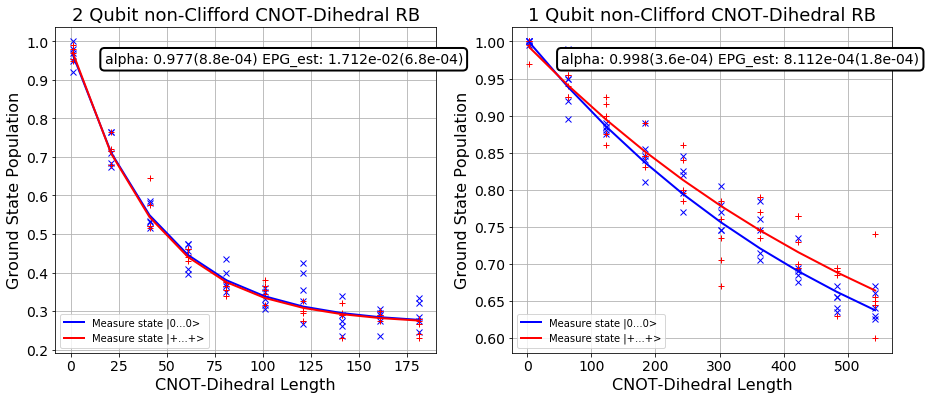

In [12]:
#Plot the joint RB data
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    joint_rb_fit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit non-Clifford CNOT-Dihedral RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

### Predicted Gate Fidelity

From the known depolarizing errors on the simulation we can predict the **fidelity**. First we need to count the number of gates per a CNOT-dihedral.

The function **gates_per_clifford** takes a compiled qobj and outputs the number of basis gates in each circuit.

(Naturally, in the CNOT-dihedral group there are no u2 gates)

In [14]:
#Count the number of single and 2Q gates in the 2Q CNOT-dihedral group elements
gates_per_elmnt = rb.rb_utils.gates_per_clifford(cnotdihedral_Z_qobj_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
for i in range(len(basis_gates)):
    print("Number of %s gates per CNOT-dihedral element: %f"%(basis_gates[i],
                                                              np.mean([gates_per_elmnt[0][i],gates_per_elmnt[1][i]])))

Number of u1 gates per CNOT-dihedral element: 0.981304
Number of u2 gates per CNOT-dihedral element: 0.000000
Number of u3 gates per CNOT-dihedral element: 0.514783
Number of cx gates per CNOT-dihedral element: 1.751739


The **twoQ_clifford_error** gives measured errors in the basis gates that were used to construct the CNOT-dihedral element. It assumes that the error in the underlying gates is depolarizing. It outputs the error per a 2-qubit CNOT-dihedral element.

The input to this function is:

- **ngates:** list of the number of gates per 2Q Clifford
- **gate_qubit:** list of the qubit corresponding to the gate (0, 1 or -1). -1 corresponds to the 2Q gate.
- **gate_err:** list of the gate errors

In [15]:
#Prepare lists of the number of qubits and the errors
ngates = np.zeros(7)
ngates[0:3] = gates_per_elmnt[0][0:3]
ngates[3:6] = gates_per_elmnt[1][0:3]
ngates[6] = gates_per_elmnt[0][3]
gate_qubits = np.array([0,0,0,1,1,1,-1], dtype=int)
gate_errs = np.zeros(len(gate_qubits))
gate_errs[[1,4]] = p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[[2,5]] = 2*p1Q/2 #convert from depolarizing error to epg (1Q)
gate_errs[6] = p2Q*3/4 #convert from depolarizing error to epg (2Q)

#Calculate the predicted EPG
pred_epg = rb.rb_utils.twoQ_clifford_error(ngates,gate_qubits,gate_errs)
print("Predicted 2Q Error per a CNOT-dihedral element: %e"%pred_epg)

Predicted 2Q Error per a CNOT-dihedral element: 1.551694e-02


## 4.1) Generate interleaved non-Clifford cnot-dihedral sequences <a name='int_pur_RB'></a>

We provide the same parameters as before including a list of interleaved gated.

- **interleaved_gates:** A list of pairs of a CNOTDihedral object and a list of gates that will be interleaved (for interleaved randomized benchmarking). The length of the list would equal the length of the rb_pattern.

In [16]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
rb_opts['group_gates'] = group_gates
rb_opts['align_cliffs'] = True

X = rb.dihedral.CNOTDihedral(1)
X.flip(0)
CX01 = rb.dihedral.CNOTDihedral(2)
CX01.cnot(0, 1)
rb_opts['interleaved_gates'] = [(CX01, [('cx', 0, 1)]), (X, [('x', 0)])]

rb_cnotdihedral_Z_circs, xdata, rb_cnotdihedral_X_circs, rb_cnotdihedral_interleaved_Z_circs, \
rb_cnotdihedral_interleaved_X_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [17]:
print (rb_cnotdihedral_Z_circs[0][0])

             ┌───┐          ┌───┐   ┌──────────┐ ░                           ░ »
qr_0: |0>────┤ X ├──────────┤ X ├───┤ U1(pi/2) ├─░───────────────────────────░─»
         ┌───┴───┴────┐┌───┐└─┬─┘ ░ ├──────────┤ ░ ┌───┐ ░ ┌────────────┐ ░  ░ »
qr_1: |0>┤ U1(5.4978) ├┤ X ├──┼───░─┤ U1(pi/4) ├───┤ X ├─░─┤ U1(4.7124) ├─░──░─»
         └─┬────────┬─┘├───┤  │   ░ └──────────┘ ░ └───┘ ░ └────────────┘ ░  ░ »
qr_2: |0>──┤ U1(pi) ├──┤ X ├──■──────────────────░───────────────────────────░─»
           └────────┘  └───┘                     ░                           ░ »
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_2: 0 ══════════════════════════════════════════════════════════════════════»
                            

In [18]:
print (rb_cnotdihedral_interleaved_Z_circs[0][0])

             ┌───┐          ┌───┐   ┌──────────┐ ░                      ░      »
qr_0: |0>────┤ X ├──────────┤ X ├───┤ U1(pi/2) ├─░──────■───────────────░──────»
         ┌───┴───┴────┐┌───┐└─┬─┘ ░ └──┬───┬───┘ ░  ░   │  ┌──────────┐ ░ ┌───┐»
qr_1: |0>┤ U1(5.4978) ├┤ X ├──┼───░────┤ X ├────────░───┼──┤ U1(pi/4) ├───┤ X ├»
         └─┬────────┬─┘├───┤  │   ░    └───┘     ░  ░ ┌─┴─┐└──────────┘ ░ └───┘»
qr_2: |0>──┤ U1(pi) ├──┤ X ├──■──────────────────░────┤ X ├─────────────░──────»
           └────────┘  └───┘                     ░    └───┘             ░      »
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_2: 0 ══════════════════════════════════════════════════════════════════════»
                            

In [19]:
print (rb_cnotdihedral_X_circs[0][0])

         ┌───┐ ░     ┌───┐          ┌───┐   ┌──────────┐ ░         »
qr_0: |0>┤ H ├─░─────┤ X ├──────────┤ X ├───┤ U1(pi/2) ├─░─────────»
         ├───┤ ░ ┌───┴───┴────┐┌───┐└─┬─┘ ░ ├──────────┤ ░ ┌───┐ ░ »
qr_1: |0>┤ H ├─░─┤ U1(5.4978) ├┤ X ├──┼───░─┤ U1(pi/4) ├───┤ X ├─░─»
         ├───┤ ░ └─┬────────┬─┘├───┤  │   ░ └──────────┘ ░ └───┘ ░ »
qr_2: |0>┤ H ├─░───┤ U1(pi) ├──┤ X ├──■──────────────────░─────────»
         └───┘ ░   └────────┘  └───┘                     ░         »
 cr_0: 0 ══════════════════════════════════════════════════════════»
                                                                   »
 cr_1: 0 ══════════════════════════════════════════════════════════»
                                                                   »
 cr_2: 0 ══════════════════════════════════════════════════════════»
                                                                   »
«                        ░ ┌────────────┐┌───┐   ┌───┐       ░     ┌───┐┌─┐»
«qr_0: ──────────────────░

In [20]:
print (rb_cnotdihedral_interleaved_X_circs[0][0])

         ┌───┐ ░     ┌───┐          ┌───┐   ┌──────────┐ ░                     »
qr_0: |0>┤ H ├─░─────┤ X ├──────────┤ X ├───┤ U1(pi/2) ├─░──────■──────────────»
         ├───┤ ░ ┌───┴───┴────┐┌───┐└─┬─┘ ░ └──┬───┬───┘ ░  ░   │  ┌──────────┐»
qr_1: |0>┤ H ├─░─┤ U1(5.4978) ├┤ X ├──┼───░────┤ X ├────────░───┼──┤ U1(pi/4) ├»
         ├───┤ ░ └─┬────────┬─┘├───┤  │   ░    └───┘     ░  ░ ┌─┴─┐└──────────┘»
qr_2: |0>┤ H ├─░───┤ U1(pi) ├──┤ X ├──■──────────────────░────┤ X ├────────────»
         └───┘ ░   └────────┘  └───┘                     ░    └───┘            »
 cr_0: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_1: 0 ══════════════════════════════════════════════════════════════════════»
                                                                               »
 cr_2: 0 ══════════════════════════════════════════════════════════════════════»
                            

## 4.2) Generate purity non-Clifford cnot-dihedral sequences

We provide the same parameters as before and the following parameter for purity rb.

In case of purity rb, all simultaneous sequences should have the same dimension (e.g. only 1-qubit sequences, or only 2-qubit sequences etc.), and there is no length multiplier.

- **is_purity=True**


In [21]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = [[0,2]]
rb_opts['group_gates'] = group_gates
rb_opts['align_cliffs'] = True
rb_opts['is_purity'] = True

rb_cnotdihedral_Z_circs, xdata, npurity = rb.randomized_benchmarking_seq(**rb_opts)

In [22]:
print (rb_cnotdihedral_Z_circs[0][8][0])

         ┌──────────┐                      ┌───┐                    ░  ░ »
qr_0: |0>┤ U1(pi/2) ├───────■──────────────┤ X ├──■─────────────────░──░─»
         └──────────┘       │              └─┬─┘  │                 ░  ░ »
qr_1: |0>───────────────────┼────────────────┼────┼──────────────────────»
         ┌──────────┐┌───┐┌─┴─┐┌──────────┐  │  ┌─┴─┐┌────────────┐ ░  ░ »
qr_2: |0>┤ U1(pi/4) ├┤ X ├┤ X ├┤ U1(pi/2) ├──■──┤ X ├┤ U1(2.3562) ├─░──░─»
         └──────────┘└───┘└───┘└──────────┘     └───┘└────────────┘ ░  ░ »
 cr_0: 0 ════════════════════════════════════════════════════════════════»
                                                                         »
 cr_1: 0 ════════════════════════════════════════════════════════════════»
                                                                         »
«                        ┌───┐                   ┌────────────┐ ┌──────────┐ »
«qr_0: ───────────────■──┤ X ├────────────────■──┤ U1(4.7124) ├─┤ Ry(pi/2) ├─»
«                

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright